<h2><center>ASSIGNMENT 3</center></h2>
<h2><center>DEEP ASHISH JARIWALA, JAYDEEP SINGH</center></h2>
<h2><center>GROUP - 31</center></h2>
<h2><center>Q: CM4</center></h2>

### IMPORTING LIBRARIES

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set()

### IMPORTING THE DATASET

In [2]:
from datasets import load_dataset
dataset = load_dataset('climate_fever')

Using custom data configuration default
Reusing dataset climate_fever (C:\Users\DEEP\.cache\huggingface\datasets\climate_fever\default\1.0.1\3b846b20d7a37bc0019b0f0dcbde5bf2d0f94f6874f7e4c398c579f332c4262c)


In [3]:
dataset['test']

Dataset({
    features: ['claim_id', 'claim', 'claim_label', 'evidences'],
    num_rows: 1535
})

Observing the dataset, we see that the dataset is in the form of a dictionary and we will use claim and evidences as features to train our data, since these include sentences which can be used to train our model to generate word embeddings. 

### CONSTRUCTING CORPUS --- ALL SENTANCES IN THE DATASET

In [4]:
corpus = []
for item in dataset['test']:
    corpus.append(item['claim'])
    for evidence in item['evidences']:
        corpus.append(evidence['evidence'])

### TEXT PREPROCESSING USING NLTK

<p>As part of data preprocessing, following tasks are performed:<p>
<ul>
            <li>Tokenisation of the dataset</li>
            <li>Conversion to lowercase</li>
            <li>Removal of stopwords</li>
            <li>Removing punctuations, numbers and special characters</li>
            <li>Lemmatization</li>
            <li>Stemming</li>
</ul>

<p>Details of the preprocessing steps performed on the dataset:<p>
<ul>
            <li>As part of tokenization, we will split longer strings into texts of smaller tokens. Further processing will be done on the text only after it has been appropriately tokenized. Note that the input to word2vec will be a list of tokenized sentences, so that the context of each word when used in a sentence is preserved.</li>
            <li>We are converting all the data to lowercase do that same words are not treated differently because of difference in cases.This is neceassary so that words 'Earth' and 'earth' have same meaning but when not converted to lowercase, these would be treated as two different words in vector space.</li>
            <li>After that we need to remove stop words, these are the words which don't add any additional value to the document.Here we are using nltk library to download all the stop words in english language and then we filter our corpus so that it does not include these stop words.</li>
    <li>Numbers are generally converted to words when they contain a very useful information about the data for example in banking/financial data. Our data contains information about climate , where numbers are not adding any additional information to the data. So in this case, we are removing the numbers.</li>
<li>All the punctuation, numbers and special characters are removed from the corpus, as these are unnecesarry symbols and do not contain any additional information about the data. All these characters will only create unnecessary vectors in the vector space.</li>
            <li>Lemmatization reduces the words present in different forms to their base form which is also a meaningful dictionary word. It is necessary to reduce the text ambiguity. Here, we are using WordNet lemmatizer from the nltk library to lemmatize the text. </li>
            <li>Stemming is a text-normalisation technique that removes the prefix and affix from the words. For example words like "wait", "waiting", "waited", "waits" are reduced to "wait". We are using PorterStemmer in the nltk library to stem the tokens in the corpus. It is necessary as it reduces the converts different variations of the same word to a same form.</li>
</ul>

In [5]:
# TOKENIZING CORPUS TO PREPARE FOR Word2Vec EMBEDDING
from nltk.tokenize import word_tokenize
words_corpus = [word_tokenize(sentence) for sentence in corpus]

# TO REMOVE STOPWORDS
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words=set(stopwords.words("english"))
fil_list = []
for sentence_list in words_corpus:
    lower_case_sentence = [word.lower() for word in sentence_list]
    fil_list.append(list(filter(lambda x: x not in stop_words,lower_case_sentence)))

# LOWER CASE THE TEXT, REMOVING SPECIAL CHARACTERS AND INTEGERS
import re
final_corpus = []
for sentence_list in fil_list:
    final_corpus.append(list(filter(lambda x: not bool(re.match('[^a-zA-Z]',x)), sentence_list)))

# LEMMATING    
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
final_corpus_lem = []
for sentence_list in final_corpus:
    final_corpus_lem.append(list(filter(lambda x: lemma.lemmatize(x),sentence_list)))

# STEMMING
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
final_corpus_stem = []
for sentence_list in final_corpus_lem:
    final_corpus_stem.append(list(filter(lambda x: stemmer.stem(x),sentence_list)))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DEEP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DEEP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### TRAIN TEST SPLITING

<p>After all the data preprocessing steps are complete, we split our data into train and test sets. An important point to note here is that word2vec needs the context of the words to generate correct embeddings. Thus we keep the context of the words same as in the input data and perform the split on the basis of the sentences in the input data. We split our data such that the train data contains 80% of the sentences and test set contains 20% of the sentences. (The total number of words will be different in both the sets as length of sentences may vary). The purpose of splitting the dataset is check the difference in embedding when the dimensions of Word2Vec embeddings are reduced using dimensionality reduction techniques (T-SNE in this case).</p>

In [6]:
from sklearn.model_selection import train_test_split
train_corpus, test_corpus = train_test_split(final_corpus_stem, test_size = 0.2, random_state = 0)

### TRAINING THE MODEL USING Word2Vec

<p>The entire dataset is trained using Word2Vec model at default parameters from gensim library.</p>

In [7]:
from gensim.models import Word2Vec
model = Word2Vec(final_corpus_stem, workers = 1)

### SEPERATE TRAIN SET AND TEST SET EMBEDDINGS FROM TRAINED MODEL

<p>This process involves two steps:<p>
<ul>
            <li>The splitted part of  dataset (train and test set) are converted to a flat list.</li>
            <li>Using the vocab of the trained model embeddings for test set is extracted for dimensionality reduction using T-SNE</li>
</ul>

In [8]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

final = flatten_list(test_corpus)

def getList(dict): 
    return list(dict.keys()) 
       
list_final = getList(model.wv.vocab)

common = []
for i in range(len(final)):
    for j in range(len(list_final)):
        if final[i] == list_final[j]:
            common.append(final[i])
            
## new list contains all the words in the test set which are present in the vocabulary 
new_list = set(common)

labels = []
tokens = []
## 
for word in new_list:
    tokens.append(model[word])
    labels.append(word)
## tokens is the list of embeddings of the words in test set

C:\Users\DEEP\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


### PART 1:   APPLYING T-SNE ON TEST SET EMBEDDINGS

<p>T-SNE is an unsupervised dimensionality reduction tool used to visualize higher dimensional data (as a 2D or 3D plot). It captures the non linearity of the orginal data and maps it to lower dimensions with a very good relative similarity to the original data. Based on the embeddings, 2D plot visualization using t-sne will be best suited to check the test data. T-sne has a large set of hyperparameter which are difficult to tune. Generally the perplexity vary between 5 to 50 and it should be near to the sqrt(N), N is the number of data points. For our case as the length of data is 3119, so sqrt (3119) ~ 50.</p>

### PART 2:  VISUALIZATION OF T-SNE EMBEDDINGS FOR TEST SET

In [9]:
from sklearn.manifold import TSNE

tsne_model = TSNE(perplexity = 50)
new_values = tsne_model.fit_transform(tokens)

## data-frame for the t-sne embeddings of the test dataset
test_set_tsne_df = pd.DataFrame(data = new_values, index = labels)

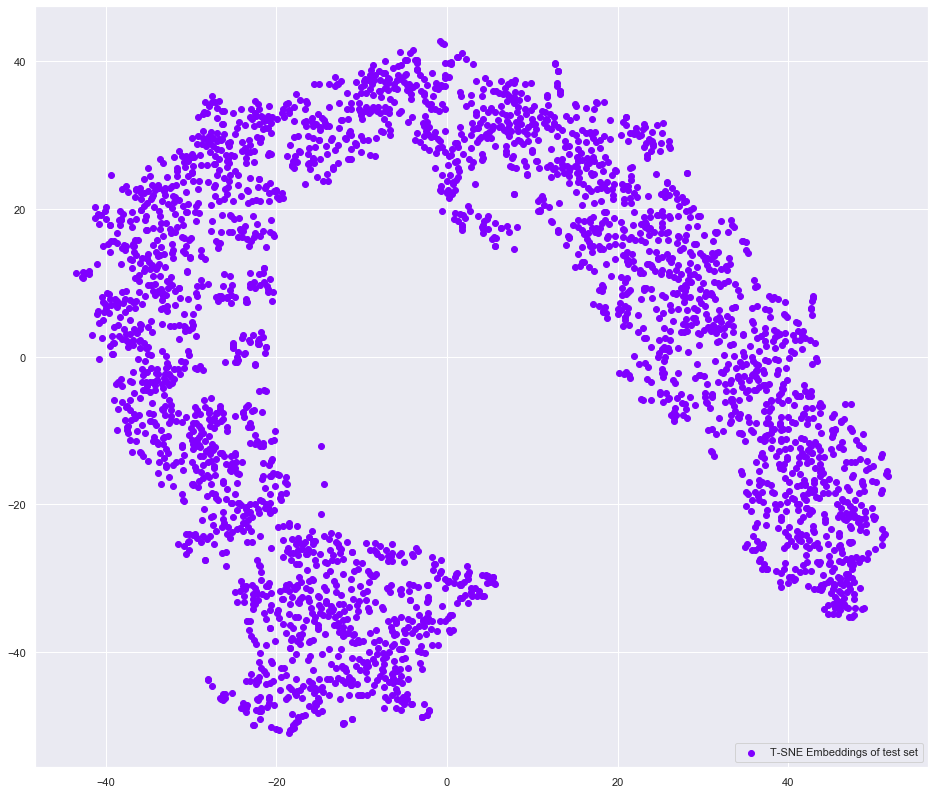

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 14))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_2d('T-SNE Embeddings of test set', new_values, a=1)

C:\Users\DEEP\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\DEEP\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0, flags=flags)


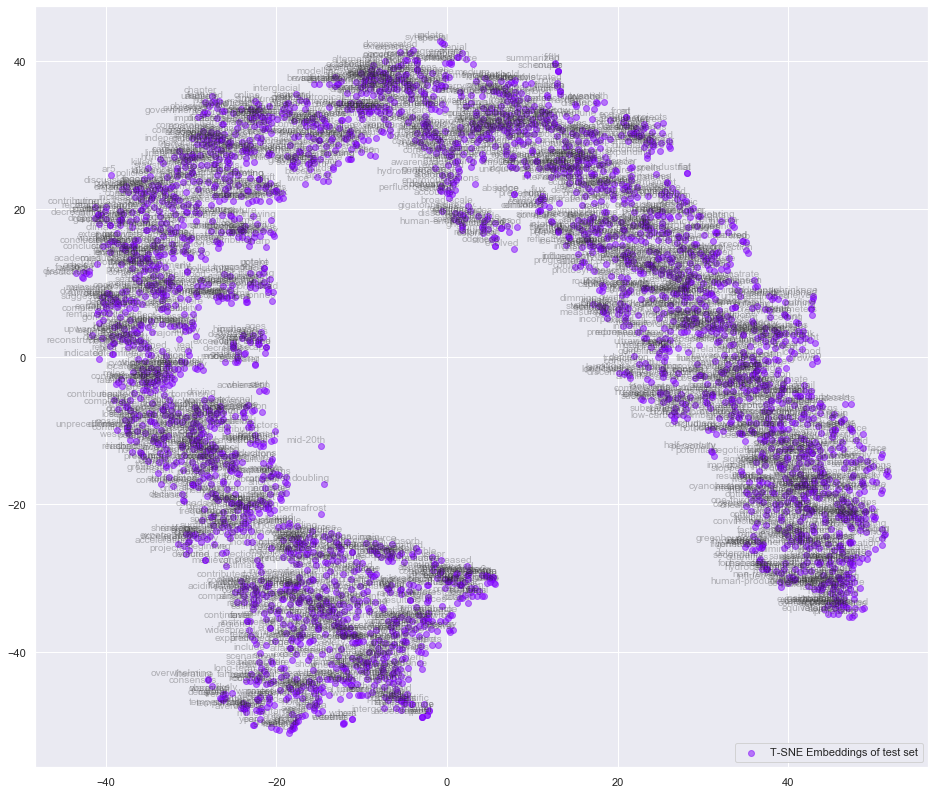

In [12]:
tsne_plot_2d('T-SNE Embeddings of test set', new_values, labels, 0.5)

<p>The above graph shows 2D plot for the test set embedding, with and without annotations. The following key points are observed using these plots:<p>
<ul>
            <li>Compared to other dimensions 2D shows the best visualization of the embeddings.</li>
            <li>It can be observed that few clusters are formed, which indicates that words with similar meaning (high cosine score) are placed around together.</li>
            <li>It is difficult to interpret the annotations of the words in the cluster as they are very closely spaced.</li>
</ul>

In [13]:
embedding_df = test_set_tsne_df
embedding_df

,0,1
dissolved,0.885061,18.608599
substances,26.861858,-7.828723
safe,31.099306,-5.179843
transient,45.166763,-29.029575
major,0.129564,-35.338482
...,...,...
low-carbon,26.657639,-8.757663
biological,-34.100842,14.212537
fund,-2.213417,30.173513
novel,29.582308,7.862001


### PART 3: COMPARISON OF T-SNE WITH WORD2VEC EMBEDDINGS 

### COSINE SIMILARITY FUNCTION FOR T-SNE EMBEDDING CALCULATIONS

In [14]:
embedding_df.reset_index(level=0, inplace=True)

def cosine_calc(inp):
    score = []
    word_list = []
    for i in range(len(new_list)):
        if inp == embedding_df['index'][i]:
                for j in range(len(new_list)):
                    cosine_similarity = np.dot(new_values[i], new_values[j])/(np.linalg.norm(new_values[i])
                                                                              * np.linalg.norm(new_values[j]))
                    score.append(cosine_similarity)
                    word_list.append(embedding_df['index'][j])
                cosine_scores = pd.DataFrame({'word': word_list, 'cosine_score': score}, columns = ['word','cosine_score'])
                cosine_scores = cosine_scores.sort_values(by=['cosine_score'], ascending=False)
                return cosine_scores.head(10)

<p>A seperate cosine similiarity calculation function is defined to find the 10 most similar word using the T-SNE embeddings. Based on these calculations, difference in the most similar word are noted in the table below to show the difference in output when compared to Word2Vec embeddings.</p>

In [15]:
print("Most similar words to degrees")
print("\nResults by Word2vec model: ")
print(model.wv.most_similar('degrees'))
print("\nResults by T-SNE embeddings: " ) 
print(cosine_calc('degrees'))

Most similar words to degrees

Results by Word2vec model: 
[('celsius', 0.9981396198272705), ('fahrenheit', 0.9981289505958557), ('mm/yr', 0.9890832901000977), ('occurred', 0.9875670075416565), ('warmer', 0.9852510690689087), ('judge', 0.9847418665885925), ('end', 0.9843641519546509), ('anomaly', 0.9833292961120605), ('projected', 0.9833246469497681), ('risen', 0.9818987250328064)]

Results by T-SNE embeddings: 
          word  cosine_score
1563   degrees      1.000000
1316    period      1.000000
911   patterns      0.999999
2131  climatic      0.999999
3108   heating      0.999997
347    million      0.999997
1295  reported      0.999995
469       east      0.999995
2641   glacial      0.999992
675        ago      0.999987


In [16]:
print("Most similar words to greenhouse")
print("\nResults by Word2vec model: ")
print(model.wv.most_similar('greenhouse'))
print("\nResults by T-SNE embeddings: " ) 
print(cosine_calc('greenhouse'))

Most similar words to greenhouse

Results by Word2vec model: 
[('heat-trapping', 0.9940437078475952), ('gases', 0.9898431301116943), ('gas', 0.9856014847755432), ('emissions', 0.9854976534843445), ('concentrations', 0.9740851521492004), ('unabated', 0.9686160087585449), ('ghgs', 0.9650759696960449), ('atmosphere', 0.964326024055481), ('anthropogenic', 0.9640756249427795), ('methane', 0.9620050191879272)]

Results by T-SNE embeddings: 
                word  cosine_score
2273      greenhouse      1.000000
674            gases      0.999999
939          dioxide      0.999992
2938          carbon      0.999992
1951         methane      0.999977
459   concentrations      0.999865
1445             gas      0.999832
950               co      0.999743
1145      atmosphere      0.999608
2714     atmospheric      0.999581


In [17]:
print("Most similar words to hemisphere")
print("\nResults by Word2vec model: ")
print(model.wv.most_similar('hemisphere'))
print("\nResults by T-SNE embeddings: " ) 
print(cosine_calc('hemisphere'))

Most similar words to hemisphere

Results by Word2vec model: 
[('northern', 0.9930442571640015), ('warm', 0.9883240461349487), ('medieval', 0.9846284985542297), ('data', 0.9842355847358704), ('satellite', 0.9769786596298218), ('deduce', 0.9769569635391235), ('summer', 0.9761291742324829), ('hottest', 0.9759365320205688), ('record', 0.9744352102279663), ('glacial', 0.9743995070457458)]

Results by T-SNE embeddings: 
            word  cosine_score
276   hemisphere      1.000000
2814     warmest      1.000000
966          set      1.000000
675          ago      1.000000
1768      decade      0.999999
2737      cooler      0.999999
586         year      0.999998
2641     glacial      0.999998
462          per      0.999998
1295    reported      0.999996


In [18]:
print("Most similar words to antarctica")
print("\nResults by Word2vec model: ")
print(model.wv.most_similar('antarctica'))
print("\nResults by T-SNE embeddings: " ) 
print(cosine_calc('antarctica'))

Most similar words to antarctica

Results by Word2vec model: 
[('loss', 0.9960829019546509), ('mass', 0.9959849715232849), ('caps', 0.9953341484069824), ('land-based', 0.9948154091835022), ('alpine', 0.9939813017845154), ('melt', 0.9936772584915161), ('shrinkage', 0.9928848743438721), ('shelves', 0.9921891689300537), ('extents', 0.9912190437316895), ('antarctic', 0.9910547733306885)]

Results by T-SNE embeddings: 
            word  cosine_score
1944      winter      1.000000
2950  antarctica      1.000000
95     antarctic      1.000000
914     southern      1.000000
2982      sheets      1.000000
1436       sheet      0.999999
2538    glaciers      0.999999
254      overall      0.999999
2479  contribute      0.999999
2371   greenland      0.999998


In [19]:
print("Most similar words to greenland")
print("\nResults by Word2vec model: ")
print(model.wv.most_similar('greenland'))
print("\nResults by T-SNE embeddings: " ) 
print(cosine_calc('greenland'))

Most similar words to greenland

Results by Word2vec model: 
[('sheet', 0.9974882006645203), ('sheets', 0.9953221678733826), ('melting', 0.994169294834137), ('ice', 0.9934372305870056), ('glaciers', 0.9886044263839722), ('antarctic', 0.9879673719406128), ('arctic', 0.9808635711669922), ('caps', 0.9734035730361938), ('loss', 0.9671356678009033), ('age', 0.9647952318191528)]

Results by T-SNE embeddings: 
            word  cosine_score
2371   greenland      1.000000
1436       sheet      1.000000
2982      sheets      0.999999
2987     without      0.999999
2950  antarctica      0.999998
95     antarctic      0.999998
1944      winter      0.999998
914     southern      0.999997
1733      arctic      0.999997
931      forests      0.999996


<table>
  <tr>
    <th>Word</th>
    <th>Most_similar using Word2Vec (Cosine measure)</th>
    <th>Most_similar using T-SNE (Cosine measure)</th>
  </tr>
  <tr>
    <td>Degrees</td>
    <td>celsius, fahrenheit, warmer, occurred, mm/yr</td>
    <td>periods, patterns, climatic, heating, glacial</td>
   </tr>
  <tr>
    <td>greenhouse</td>
    <td>heat-trapping, gases, emissions, concentrations, atmosphere</td>
    <td>gases, dioxide, co2, methane, atmosphere, carbon</td>
   </tr>
  <tr>
    <td>hemisphere</td>
    <td>northern, warm, data, decades, medieval, satellite</td>
    <td>warmest, decade, set, year, cooler</td>
   </tr>
   <tr>
    <td>antarctica</td>
    <td>glaciers, loss, caps, land-based, alpine</td>
    <td>glaciers, sheets, antarctic, winter, greenland</td>
   </tr>
   <tr>
    <td>greenland</td>
    <td>sheets, melting, ice, glaciers, antarctic, caps</td>
    <td>winter, greenland, arctic, sheet, forests, winter</td>
   </tr>
</table>

<p>It can be seen that most similar words using t-SNE embedding are different compared to the embedding of trained Word2Vec model. The information conveyed by Word2Vec embeddings are more appropriate compared to T-SNE embeddings as the number of dimensions are reduced in T-SNE that can change the cosine similarity scores among different words. It can also be seen that the information provided by T-SNE embeddings are correct in many cases though not exactly related to that words.</p>

### T-SNE EMBEDDING VISUALIZATION FOR MOST SIMILAR WORDS

<p>Using user built functions, we have incorporated a method to represent the most similar word (found using T-SNE embeddings) and plot it as single colour (in a group), an approach which is similar to plotting 10 nearest neighbors (in out case most similar word found using T-SNE embedding)<p>
<ul>
            <li>A key of words is decided, whose most similar words are to be plotted.</li>
            <li>Based on the T-SNE embeddings, most similar words are calculated using the cosine_calc function.</li>
            <li>All the similar embeddings and words are clustered in a single group (in our case using colours).</li>
            <li>Based on the T-SNE embadding a graph is constructed to represent similar groups based on cosine metric.</li>
</ul>

In [20]:
test_set_tsne_df = pd.DataFrame(new_values, index = new_list, columns = ['D1','D2'])
test_set_tsne_df.head()

keys = ['greenhouse', 'deforestation', 'arctic', 'industrial', 'energy', 'temperature', 'surface', 'scientific', 'radiation']
tsne_similarity_list = [list(cosine_calc(word)['word']) for word in keys]

embedding_clusters = []
word_clusters = []

for similar_list in tsne_similarity_list:
    embeddings = []
    words = []
    for word in similar_list:
        words.append(word)
        embeddings.append(list(test_set_tsne_df.loc[word][:]))
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
embedding_clusters = np.array(embedding_clusters)

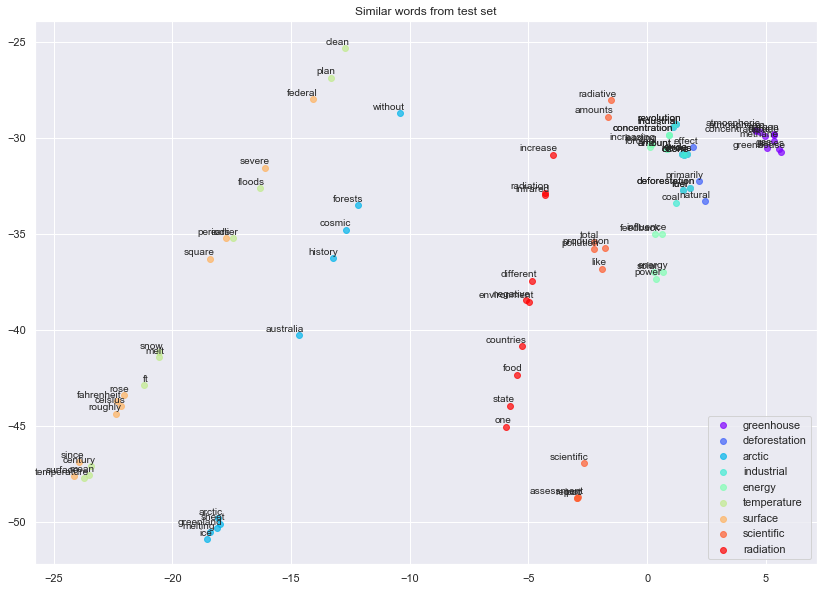

In [22]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(14, 10))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from test set', keys, embedding_clusters, word_clusters, 0.7,
                        'similar_words.png')

<p>There is a clear seperation between words of same type and having a strong cosine similarity score.</p>
<ul>
            <li>All the vector embeddings start from (0,0) and move away in a single direction based on the classes.</li>
            <li>Since cosine similarity score is computed using vector representation of embeddings, it can be observed that similar score based words are lying very close to each other (approximatly on a single vector) in the vector space.</li>
            <li>Compared to PCA the embeddings are clustered very close to each other and all the vectors are in the same quadrant from (0,0), which was different in case of PCA.</li>
            <li>Words like carbon, oil, solar are located nearby to greenhouse (denoted using purple) as they have a similar cosine score.</li>
            <li>Words like fossil, anthropogenic are located nearby to energy (denoted using green) as they have a similar cosine score.</li>
            <li>Words like economic, environmental, health are located nearby to radiation (denoted using red) as they have a similar cosine score.</li>
            <li>Words like human-caused, fuel, revolution are located nearby to deforsetation (denoted using dark blue) as they have a similar cosine score.</li>
            <li>Words like human, fossil, fuels are located nearby to industrial (denoted using cyan) as they have a similar cosine score.</li>
            <li>Words like greenland, sheet, antarctic are located nearby to arctic (denoted using blue) as they have a similar cosine score.</li>
            <li>Words like range, high, states are located nearby to temperature (denoted using light green) as they have a similar cosine score.</li>
            <li>Words like degrees, rate, million are located nearby to surface (denoted using light orange) as they have a similar cosine score.</li>
            <li>It can be seen that temperature and surface are very closely placed as they have a siginifcant relationship among them based on their similarity. Moreover, their similar word's embeddings are also placed very nearby.</li>
</ul>